In [1]:
import numpy as np
import pandas as pd
import os
import scipy
import corner
import matplotlib.pyplot as plt
import time
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")
import ultranest

# %load_ext autoreload
# %autoreload 

import jax
import jax.numpy as jnp
import numpyro.distributions as dist

Using cpu device


In [2]:
import logging
logger = logging.getLogger("ultranest")
logger.addHandler(logging.NullHandler())
logger.setLevel(logging.WARNING)

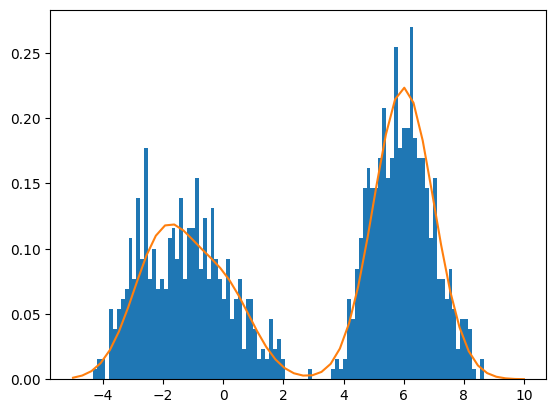

In [30]:

def get_model(a, b, c):
    mixture1 = dist.MixtureGeneral(
        dist.Categorical(probs=jnp.array([b, 1-b])), 
        [dist.Normal(loc=-2.0, scale=1.0), 
         dist.Normal(loc=0.0, scale=1.0),]
    )

    mixture2 = dist.MixtureGeneral(
        dist.Categorical(probs=jnp.array([c, 1-c])), 
        [dist.Normal(loc=0.0, scale=1.0), 
         dist.Normal(loc=6.0, scale=1.0),]
    )

    mixture = dist.MixtureGeneral(
        dist.Categorical(probs=jnp.array([a, 1-a])), 
        [mixture1, mixture2]
    )
    return mixture

def loglikelihood(param):
    a, b, c = param
    model = get_model(a, b, c)
    return jnp.sum(model.log_prob(s))

a0, b0, c0 = 0.3, 0.9, 0.2
mixture0 = get_model(a0, b0, c0)
n = 1000

rng_key = jax.random.PRNGKey(42)
s = mixture0.sample(rng_key, sample_shape=(n,))
plt.hist(s, bins=100, density=True);
x = jnp.linspace(-5, 10, num=50)
plt.plot(x, jnp.exp(mixture0.log_prob(x)))

Z=-2254.0(95.00%) | Like=-2247.13..-2247.09 [-2247.1309..-2247.1304]*| it/evals=13246/21419 eff=60.8810% N=420  
logZ = -2253.965 +- 0.263
  single instance: logZ = -2253.965 +- 0.061
  bootstrapped   : logZ = -2253.967 +- 0.112
  tail           : logZ = +- 0.238
insert order U test : converged: True correlation: inf iterations

    a                   : 0.224 │ ▁▁▁▁▁▂▃▄▄▆▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▆▇▆▅▄▃▂▁▁▁▁▁ │0.513     0.369 +- 0.051
    b                   : 0.50  │ ▁ ▁▁▁▁▁▂▃▄▅▆▆▇▇▇▇▆▅▆▆▆▇▆▆▅▆▅▅▅▄▄▅▅▅▄▄▄│1.00      0.79 +- 0.11
    c                   : 0.000 │▄▅▅▅▅▅▅▅▅▅▅▆▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▆▅▄▃▁▁▁▁▁▁ │0.304     0.132 +- 0.069

CPU times: user 4min 28s, sys: 2min 50s, total: 7min 18s
Wall time: 3min 37s


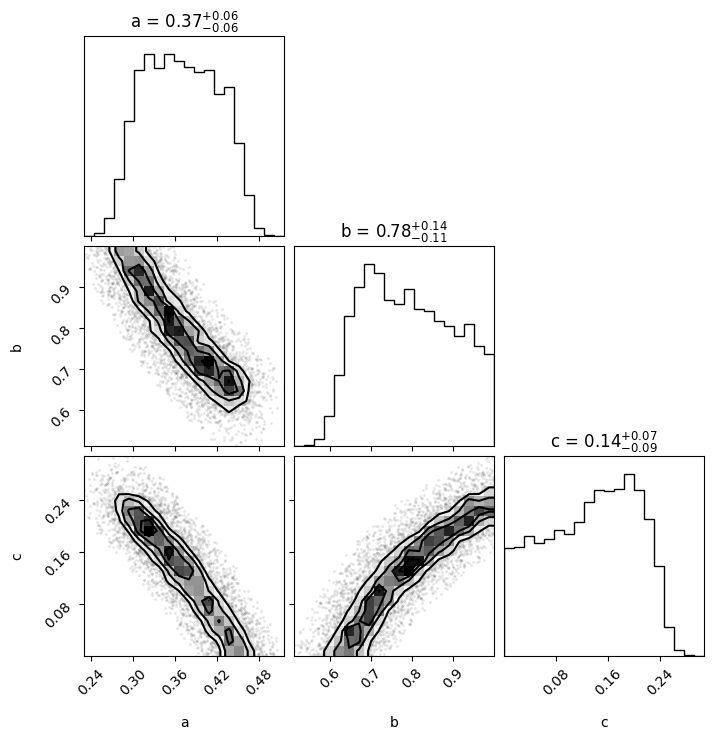

In [31]:
%%time 
param_names = ['a', 'b', 'c']
sampler = ultranest.ReactiveNestedSampler(
    param_names, 
    loglikelihood, 
)
result = sampler.run(
#     show_status=False, 
    frac_remain=0.05,
    min_num_live_points=1600,
#     min_ess=1600,
)
sampler.print_results()
# sampler.plot_trace()
sampler.plot_corner()

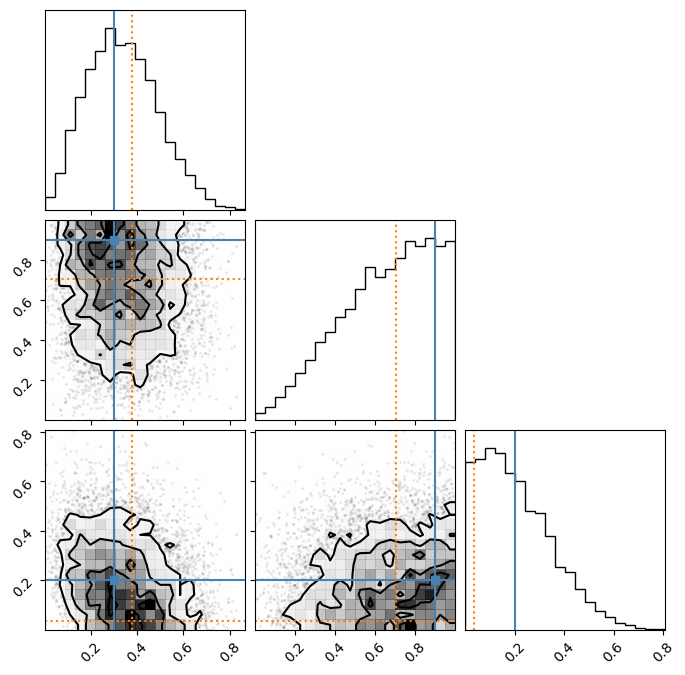

In [29]:
fig = corner.corner(
    result["samples"], 
    truths=[a0, b0, c0], 
);
corner.overplot_lines(fig, result['maximum_likelihood']['point'], color="C1", linestyle="dotted")